# Testing Refactored model

In [1]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import Model
from Model import AverageTransferFunctionModel, FrequencyDependentModel
from Model.back_prop_utils import H_th_function, round_to_sig_figs, c, torch_unwrap
from Model.plotting_utils import plot_transfer, plot_comparison, plot_loss_contributions
from Model.loss_functions import loss

# Testing AverageTransferFunctionModel Method

## Setup transfer function
We will setup a simulated experimental transfer function. This will not have noisy data between 0-0.3 THZ but we will treat it like it does in order to ensure the method is valid for experimental situations.

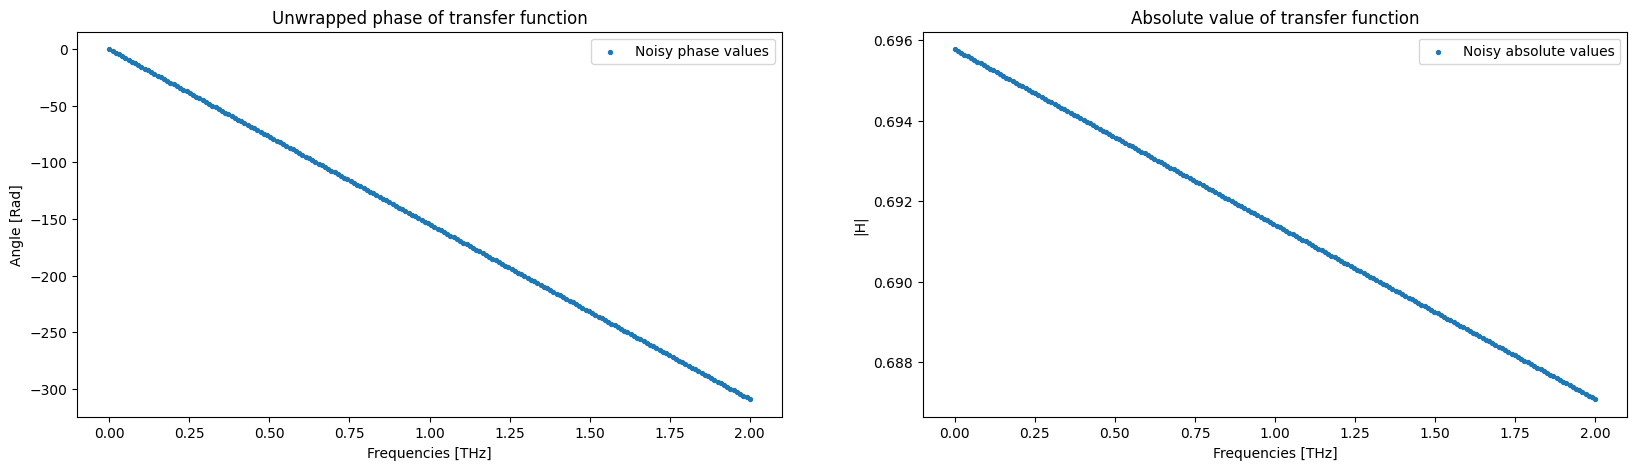

In [2]:
# Setup parameters
n = 3.46
k = -1e-4
thickness = 3 * 1e-3

# Setup frequency arrays
frequency_bounds = [0.3, 2]
full_w_THz = np.linspace(0,frequency_bounds[1], 200)
full_w_THz = torch.tensor(full_w_THz, dtype=torch.float32)

# Convert to angular freqs for calcs
full_w = full_w_THz * 2 * np.pi * 1e12

n_complex = n + 1j*k

H_exp = H_th_function(n_complex, full_w,length=thickness)

H_exp_abs = torch.abs(H_exp)
H_exp_phi = torch_unwrap(torch.angle(H_exp))

plot_transfer(full_w_THz, H_exp_abs, H_exp_phi)

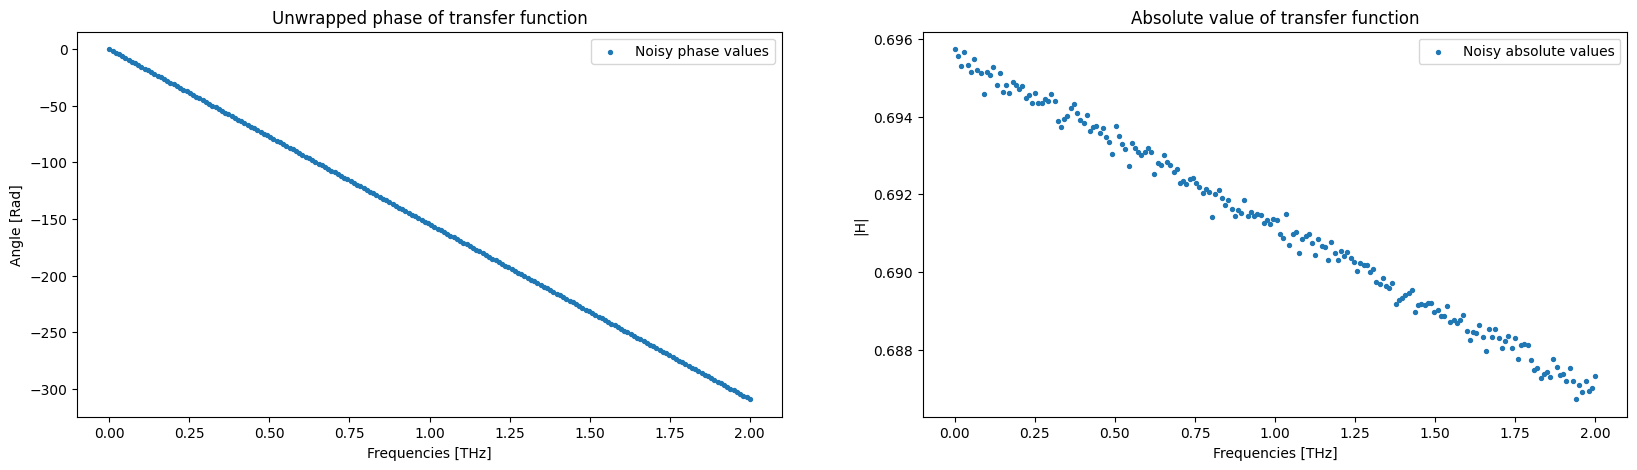

In [3]:
# Add noise to the system
noise = np.random.normal(-0.0002, 0.0002, size=len(H_exp_abs))
H_exp_abs += noise

plot_transfer(full_w_THz, H_exp_abs, H_exp_phi)

## Initalize Model

In [4]:
# Setup frequencies and values over interested range, best done with pandas
data = {
    'frequencies': full_w,
    'frequencies_THz': full_w_THz,
    'Exp_abs': H_exp_abs,
    'Exp_phi': H_exp_phi
}

df = pd.DataFrame(data=data)
filter = df['frequencies_THz'] >= 0.3

w_fitting = df['frequencies'][filter].to_numpy()
w_fitting = torch.tensor(w_fitting, dtype=torch.float32)
abs_fitting = torch.tensor(df['Exp_abs'][filter].to_numpy(), dtype=torch.float32)
phi_fitting = torch.tensor(df['Exp_phi'][filter].to_numpy(), dtype=torch.float32)

df

,frequencies,frequencies_THz,Exp_abs,Exp_phi
0,0.000000e+00,0.000000,0.695731,0.000016
1,6.314759e+10,0.010050,0.695559,-1.554490
2,1.262952e+11,0.020101,0.695293,-3.108997
3,1.894428e+11,0.030151,0.695655,-4.663503
4,2.525904e+11,0.040201,0.695337,-6.218009
...,...,...,...,...
195,1.231378e+13,1.959799,0.686916,-303.128723
196,1.237693e+13,1.969849,0.687187,-304.683167
197,1.244008e+13,1.979900,0.686938,-306.237671
198,1.250322e+13,1.989950,0.687027,-307.792206


Epoch 0: Total Loss = 33.30060958862305, Learning Rate = 0.001
Epoch 1000: Total Loss = 0.4983210861682892, Learning Rate = 0.001
Epoch 2000: Total Loss = 0.09539870172739029, Learning Rate = 1e-05
Epoch 3000: Total Loss = 0.10219348967075348, Learning Rate = 1.0000000000000004e-08
Epoch 4000: Total Loss = 0.10219348967075348, Learning Rate = 1.0000000000000004e-08
Epoch 5000: Total Loss = 0.10219348967075348, Learning Rate = 1.0000000000000004e-08
Epoch 6000: Total Loss = 0.10219348967075348, Learning Rate = 1.0000000000000004e-08
Epoch 7000: Total Loss = 0.10219348967075348, Learning Rate = 1.0000000000000004e-08
Epoch 8000: Total Loss = 0.10219348967075348, Learning Rate = 1.0000000000000004e-08
Epoch 9000: Total Loss = 0.10219348967075348, Learning Rate = 1.0000000000000004e-08
Epoch 9999: Total Loss = 0.10219348967075348, Learning Rate = 1.0000000000000004e-08
Best parameters found (Lowest Loss: 0.001101168803870678):
n: 3.4614098072052
k: -0.00010065420065075159


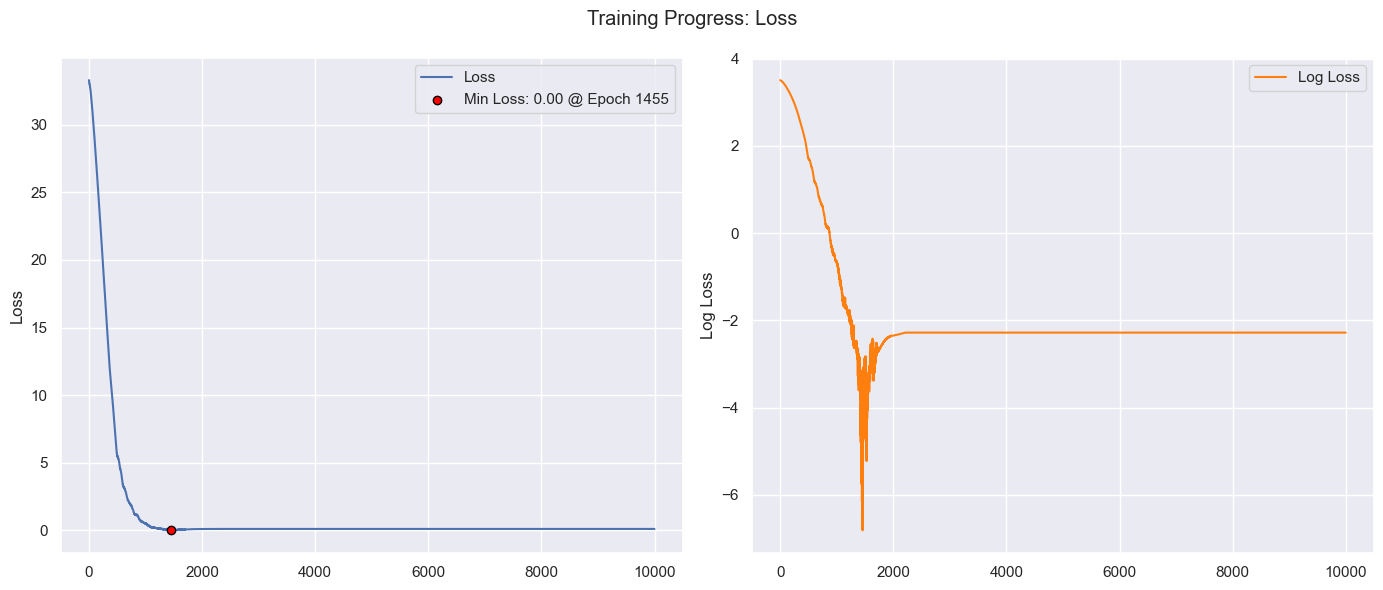

In [5]:
# Initialize model over the freqs range [0.3, 2]
avg_model = AverageTransferFunctionModel(w_tensor=w_fitting, d=thickness, ICs_n=3, ICs_k=-0.001)

# Setup Optimizer and scheduler
optimizer = torch.optim.Adam(avg_model.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.1, patience=250)

# Train model
avg_model.train_model(loss_fn=loss, H_values=abs_fitting, phi_values=phi_fitting, updates=1000, optimizer=optimizer, scheduler=scheduler)
avg_model.plot_training_curves()

In [6]:
avg_model.best_params

{'n': array(3.4614098, dtype=float32),
 'k': array(-0.00010065, dtype=float32),
 'loss': 0.001101168803870678}

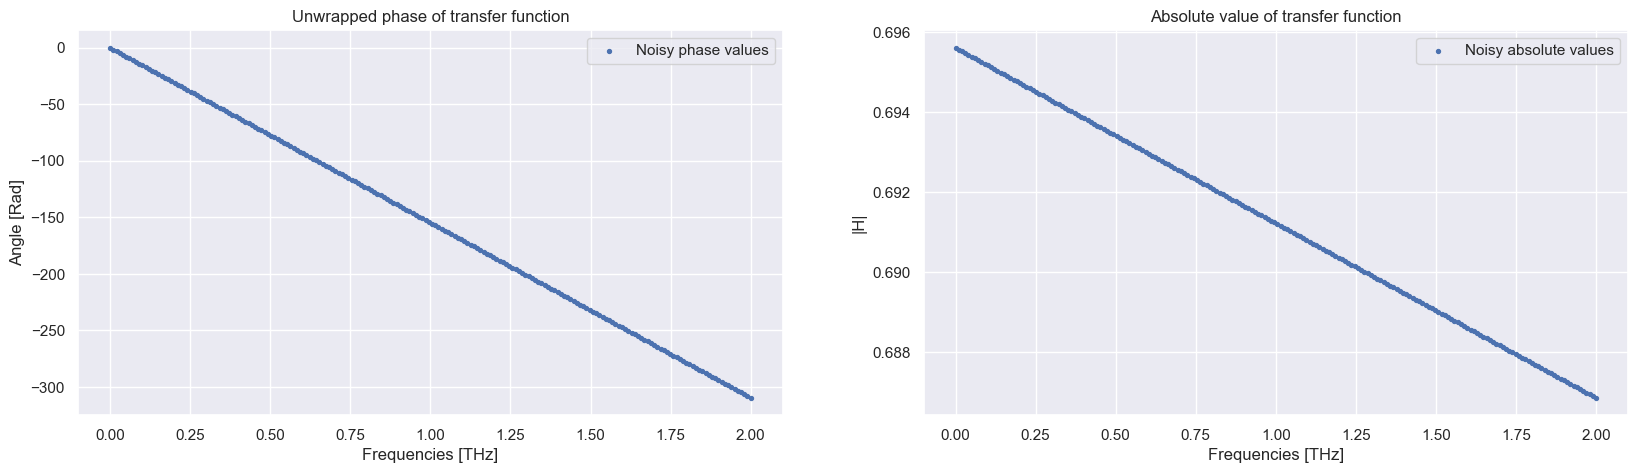

In [7]:
avg_complex_n = avg_model.best_params['n'] + 1j*avg_model.best_params['k']

recon_H = H_th_function(avg_complex_n, full_w, thickness)
recon_abs = torch.abs(recon_H)
recon_phi = torch_unwrap(torch.angle(recon_H))

plot_transfer(full_w_THz, recon_abs, recon_phi)

In [8]:
avg_model.n

Parameter containing:
tensor(3.4614, requires_grad=True)

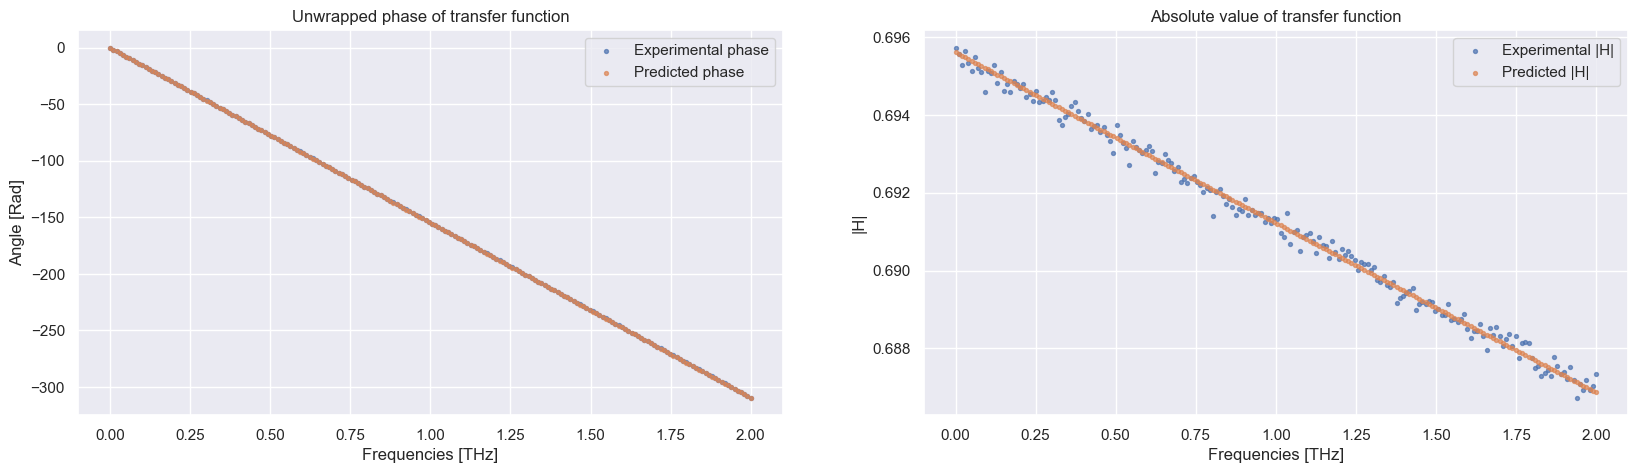

In [9]:
plot_comparison(full_w_THz, 
                exp_abs=H_exp_abs, exp_phase=H_exp_phi, 
                pred_abs=recon_abs, pred_phase=recon_phi
                )

# Test FrequencyDependentModel methods

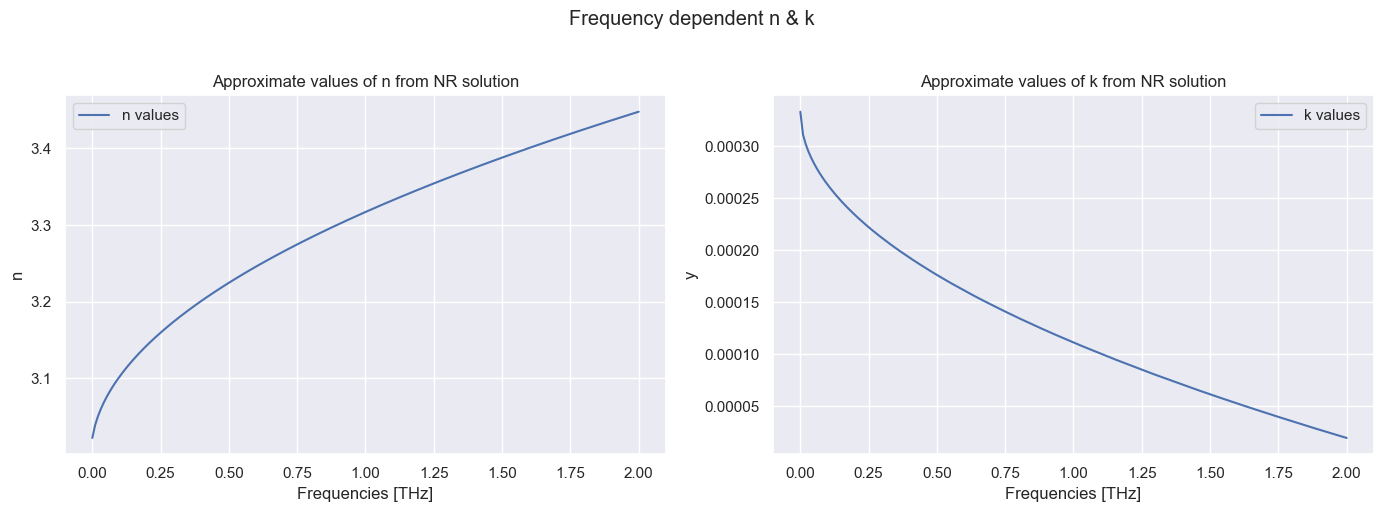

In [10]:
n = np.sqrt(0.1 * (full_w_THz + 0.005)) + 3
k = ((np.sqrt(0.000004 * full_w_THz) + 3)**-1) - 0.333

# Create the first subplot (assuming 'data1' is your first dataset)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# First plot: Approximate values of n from NR solution
sns.lineplot(x=full_w_THz, y=n, label="n values", ax=ax1)
ax1.set_title('Approximate values of n from NR solution')
ax1.yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
ax1.set_xlabel('Frequencies [THz]')
ax1.set_ylabel('n')

# Second plot (assuming 'data2' is your second dataset with x and y values)
sns.lineplot(x=full_w_THz, y=k, label="k values", ax=ax2)
ax2.set_title('Approximate values of k from NR solution')
ax2.yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
ax2.set_xlabel('Frequencies [THz]')
ax2.set_ylabel('y')

# Adjust layout and add main title if needed
plt.suptitle('Frequency dependent n & k', y=1.02)
plt.tight_layout()
plt.legend()
plt.show()

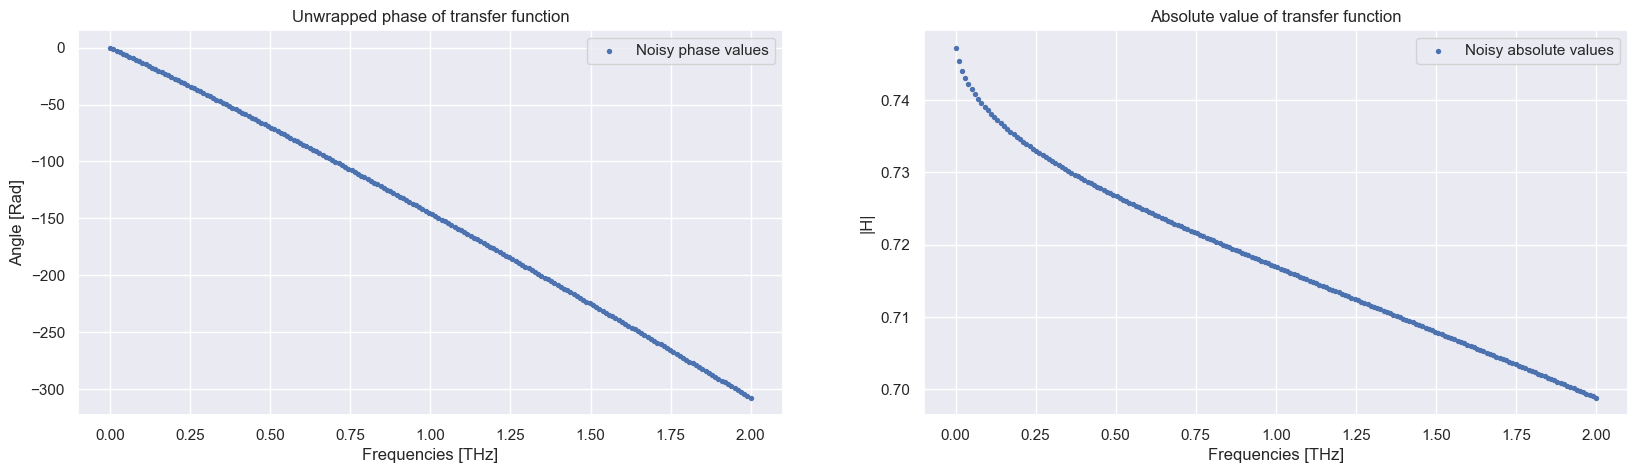

In [11]:
n_complex = n + 1j*k


freq_dep_H = H_th_function(n_complex, w=full_w, length=thickness)

# Break down into components
freq_dep_H_abs = torch.abs(freq_dep_H)
freq_dep_H_phi = torch_unwrap(torch.angle(freq_dep_H))


plot_transfer(full_w_THz, absolute_values=freq_dep_H_abs, phase_values=freq_dep_H_phi)

Epoch 0: Total Loss = 22.651165008544922, Learning Rate = 0.001
Epoch 1000: Total Loss = 22.463510513305664, Learning Rate = 1.0000000000000002e-06
Epoch 2000: Total Loss = 22.4635066986084, Learning Rate = 1.0000000000000004e-08
Epoch 3000: Total Loss = 22.4635066986084, Learning Rate = 1.0000000000000004e-08
Epoch 4000: Total Loss = 22.4635066986084, Learning Rate = 1.0000000000000004e-08
Epoch 5000: Total Loss = 22.4635066986084, Learning Rate = 1.0000000000000004e-08
Epoch 6000: Total Loss = 22.4635066986084, Learning Rate = 1.0000000000000004e-08
Epoch 7000: Total Loss = 22.4635066986084, Learning Rate = 1.0000000000000004e-08
Epoch 8000: Total Loss = 22.4635066986084, Learning Rate = 1.0000000000000004e-08
Epoch 9000: Total Loss = 22.4635066986084, Learning Rate = 1.0000000000000004e-08
Epoch 9999: Total Loss = 22.4635066986084, Learning Rate = 1.0000000000000004e-08
Best parameters found (Lowest Loss: 22.4510498046875):
n: [3.0223498 3.008634  3.0064435 3.0054357 3.0048077 3.004

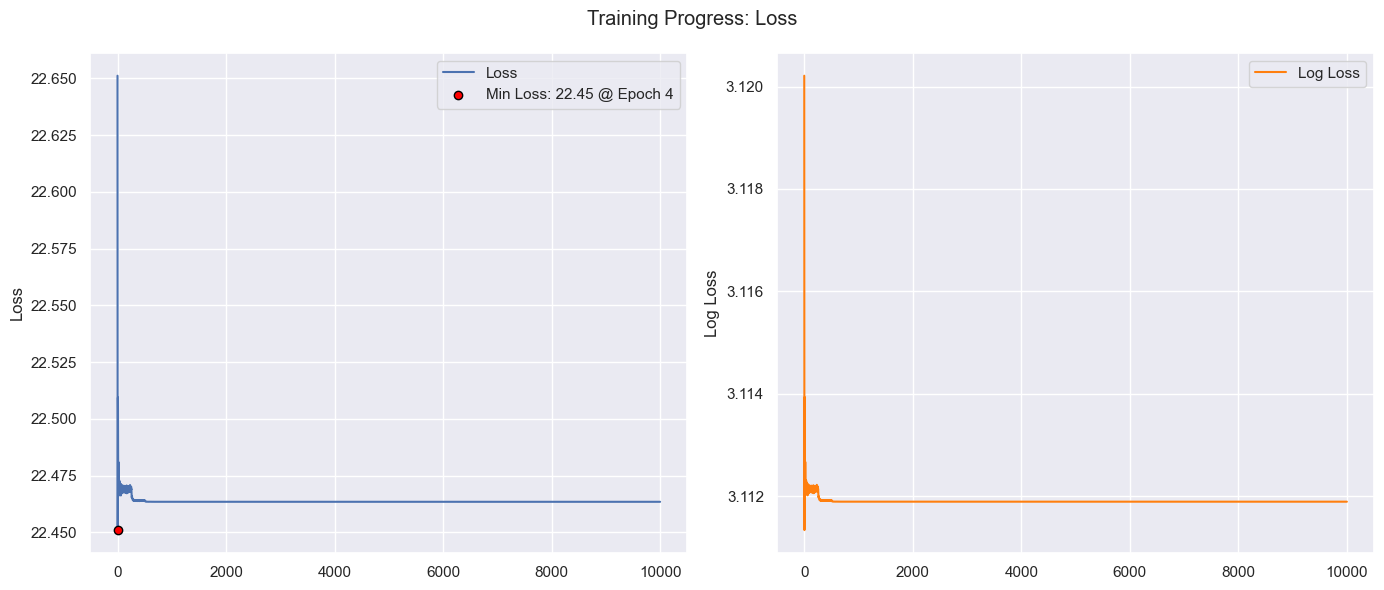

In [12]:
# First Optimize the model over the full range to ensure this is possible
freq_model = FrequencyDependentModel(full_w, thickness, ICs_n=3, ICs_k=0.001)
# Setup Optimizer and scheduler
freq_optimizer = torch.optim.Adam(freq_model.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            freq_optimizer, mode='min', factor=0.1, patience=250)

freq_model.train_model(loss_fn=loss,
                       H_values=freq_dep_H_abs,
                       phi_values=freq_dep_H_phi,
                       optimizer=freq_optimizer,
                       scheduler=scheduler,
                       updates=1000)

freq_model.plot_training_curves()

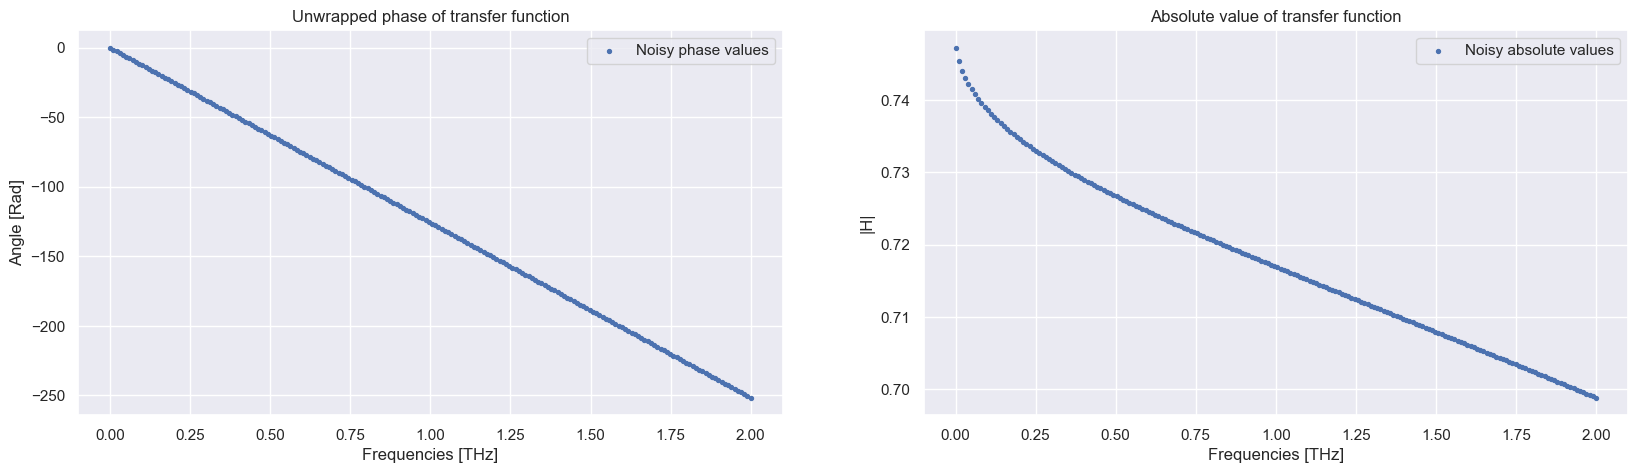

In [13]:
# Extract n and k from model
freq_n = freq_model.best_params['n']
freq_k = freq_model.best_params['k']

# Construct complex refractive index
freq_optimal_n = freq_n + 1j*freq_k
freq_optimal_n = torch.tensor(freq_optimal_n)

# Reconstruct Transfer function
freq_recon_H = H_th_function(freq_optimal_n, full_w, thickness)
freq_recon_abs = torch.abs(freq_recon_H)
freq_recon_phi = torch_unwrap(torch.angle(freq_recon_H))

plot_transfer(full_w_THz, freq_recon_abs, freq_recon_phi)

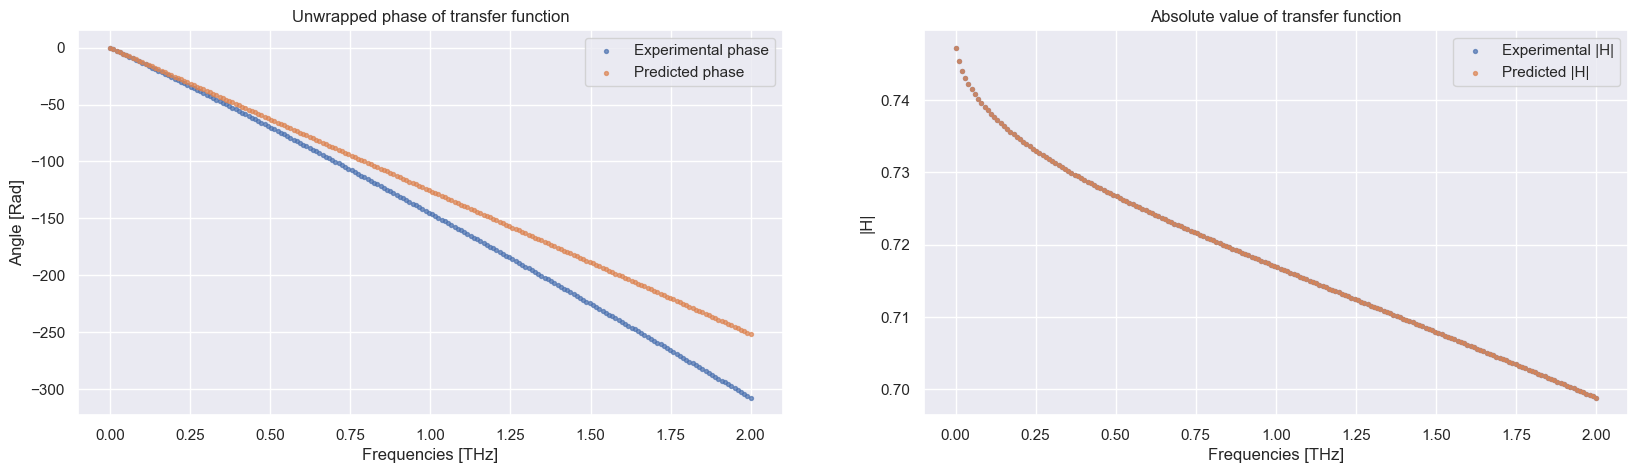

In [14]:
plot_comparison(full_w_THz, 
                exp_abs=freq_dep_H_abs, exp_phase=freq_dep_H_phi,
                pred_abs=freq_recon_abs, pred_phase=freq_recon_phi
                )

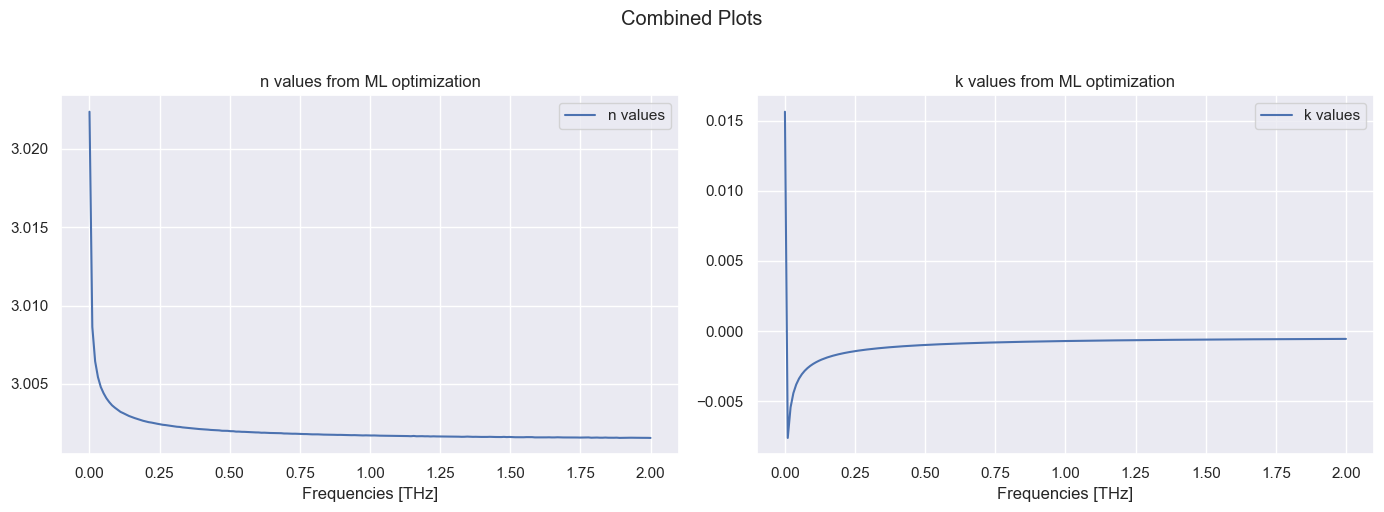

In [15]:
# Create the first subplot (assuming 'data1' is your first dataset)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# First plot: Approximate values of n from NR solution
sns.lineplot(x=full_w_THz, y=freq_n, label="n values", ax=ax1)
ax1.set_title('n values from ML optimization')
ax1.yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
ax1.set_xlabel('Frequencies [THz]')

# Second plot (assuming 'data2' is your second dataset with x and y values)
sns.lineplot(x=full_w_THz, y=freq_k, label="k values", ax=ax2)
ax2.set_title('k values from ML optimization')
ax2.yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
ax2.set_xlabel('Frequencies [THz]')

# Adjust layout and add main title if needed
plt.suptitle('Combined Plots', y=1.02)
plt.tight_layout()
plt.legend()
plt.show()